## Actual power consumption and estimations

For 11.5 MB data, batchsize 32, running on 1 GPU, \
time = 1 hour 40 min \
power = 1581170.0899999999 W = 0.43921391388888886 kWh


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
url = "nvidia/nvidia_power_pretrain.csv"
df_orig = pd.read_csv(url)

In [4]:
#it is using one gpu only

In [5]:
df_orig.timestamp = [datetime.strptime(time, "%Y/%m/%d %H:%M:%S.%f") for time in df_orig.timestamp]
df = df_orig.loc[df_orig[" utilization.gpu [%]"] > 0] #isolating training 

In [6]:
time_interval = df.iloc[-1].timestamp - df.iloc[0].timestamp
#print("Total time in seconds: {}".format(time_interval.total_seconds()))
total_time = time_interval.total_seconds()
print("seconds: {}".format(total_time))
print ("training hours: {}".format(total_time/3600))

seconds: 5991.57
training hours: 1.6643249999999998


In [7]:
time_interval1 = df_orig.iloc[-1].timestamp - df_orig.iloc[0].timestamp
#print("Total time in seconds: {}".format(time_interval.total_seconds()))
total_time1 = time_interval1.total_seconds()
print("seconds: {}".format(total_time1))
print ("total hours: {}".format(total_time1/3600))

seconds: 6004.669
total hours: 1.6679636111111111


In [8]:
mean_power =df[' power.draw [W]'].mean() 
total_power = mean_power * total_time 
sum_power = df_orig[' power.draw [W]'].sum() # total power during the time code is running
gpu_util = df[' utilization.gpu [%]'].mean()
memory_util = df[' utilization.memory [%]'].mean()
memory_used = df[' memory.used [MiB]'].mean()
print('{} total from mean \n{} summed power'.format(total_power,sum_power))
print('in kWh ', sum_power / (1000 * 3600))

1516541.3808476038 total from mean 
1581170.0899999999 summed power
in kWh  0.43921391388888886


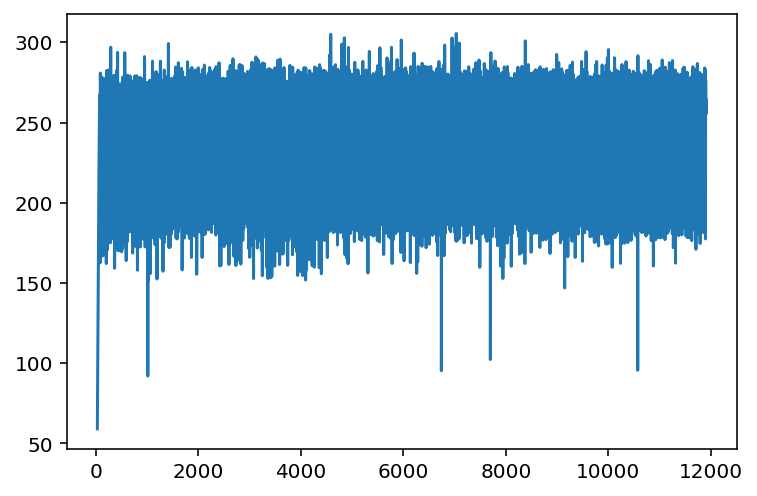

In [9]:
df[" power.draw [W]"].plot()

In [10]:
df[' power.draw [W]'].describe() 

count    5905.000000
mean      253.112520
std        32.139627
min        59.100000
25%       252.170000
50%       265.390000
75%       272.700000
max       305.490000
Name:  power.draw [W], dtype: float64

In [11]:
print("total power consumption: {} W".format(total_power))

total power consumption: 1516541.3808476038 W


In [12]:
t = total_power / (1000 * 60 *60)
print("total power consumption: {} kWh".format(t))

total power consumption: 0.42126149467988994 kWh


As per output from run_pretraining \
global step per second = 2.12.... \
examples/sec = global step * batch size = 67/68 \
the dataset has 101103 instances \
time to process = 101103 / 67 \
per epoch

In [13]:
dataset_size = 101103
estimated_time = 101103 /67
total_est_time = estimated_time * 3 #3 epochs
print(total_est_time)

4527.0


In [14]:
samples_per_sec = (dataset_size * 3) / total_time
time_per_sample = total_time / (dataset_size * 3)

print("Samples processed per sec ", samples_per_sec)
print("Time to process one sample ", time_per_sample)

Samples processed per sec  50.6226247878269
Time to process one sample  0.019754013234028662


In [15]:
# approx flops using the ai and compute equation
# Number of GPUs * (peta-flops/GTX580) * days trained * estimated utilization
gtx1080TFLOPS = 11.34  # https://www.techpowerup.com/gpu-specs/geforce-gtx-1080-ti.c2877
TFLOPs = 1 * gtx1080TFLOPS *  total_time * gpu_util
PFLOPs = TFLOPs/ 1000
PFLOPs_per_example= PFLOPs/ (dataset_size* 3)

In [16]:
PFLOPs_per_example

0.022046731250556992

In [65]:
#from the power monitor

In [68]:
print (df.iloc[-1].timestamp, df.iloc[0].timestamp)
print (df_orig.iloc[-1].timestamp, df_orig.iloc[0].timestamp)

2020-06-17 00:18:51.137000 2020-06-16 22:38:59.567000
2020-06-17 00:18:51.139000 2020-06-16 22:38:46.470000


In [44]:
power_monitor_df = pd.read_csv("results/pretrain_power_monitor.csv")

In [46]:
power_monitor_df['last_changed'] = pd.to_datetime(power_monitor_df['last_changed'], errors='coerce')
power_monitor_df.dropna(subset=['last_changed'], inplace=True)
power_monitor_df.set_index('last_changed', inplace=True)

In [67]:
start_date = '2020-06-16'
end_date = '2020-06-16'
start_time = '21:38:59'
end_time = '23:18:51'
subset_df4 = power_monitor_df.loc[start_date:end_date].between_time(start_time, end_time)[['power_consumption']]
(subset_df4['power_consumption'] - 83).sum()

569408.713

/Users/shivangi/Documents/power_monitor/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


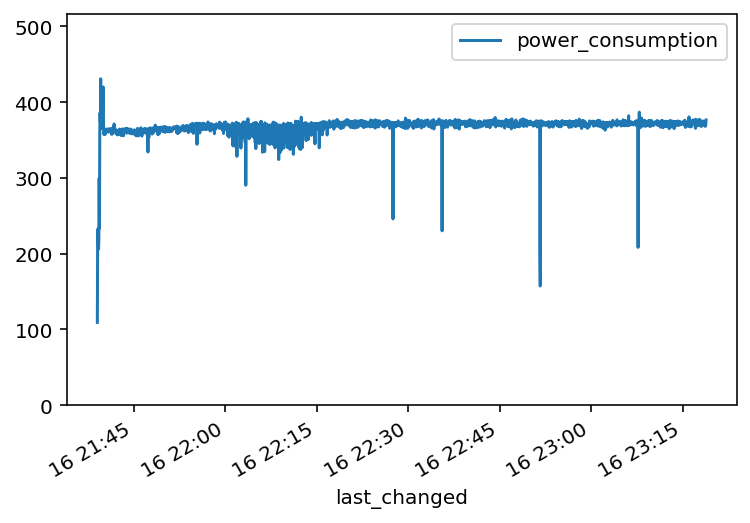

In [68]:
y_max = subset_df4['power_consumption'].max() * 1.2
subset_df4[(power_monitor_df != 0).all(1)].plot(ylim=(0,y_max))

In [62]:
from statsmodels.tsa.stattools import adfuller
def testStationary(series):
    X = series.values
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [63]:
testStationary(subset_df4["power_consumption"])

ADF Statistic: -5.020088
p-value: 0.000020
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [70]:
mean_power_monitor = subset_df4["power_consumption"].mean() - 83

In [74]:
total_power_monitor = mean_power_monitor * total_time

In [72]:
print("total power consumption from nvidia-smi: {} W".format(total_power))

total power consumption from nvidia-smi: 1516541.3808476038 W


In [75]:
total_power_monitor - total_power

190992.2340419907

In [77]:
t_pm = total_power_monitor /( 1000 * 3600)

In [79]:
print (t, t_pm)

0.42126149467988994 0.4743148930248874


Idea: can I get sample size in number of examples from the dataset size in MB


In [32]:
wiki_file_size=11.5 #MB

In [33]:
time_to_process_1MB= total_time / wiki_file_size

In [34]:
time_to_process_1MB

521.0060869565217

In [35]:
data_100MB = 100
time_100MB = time_to_process_1MB * 100
time_100MB

52100.60869565217

In [31]:
words_for_bert = (800 + 2500) #M words

In [37]:
#assuming 10 characters per word
datasize = words_for_bert * 10 # MB

In [39]:
time_bert = time_to_process_1MB * datasize
time_bert #seconds

171963269.06086954

In [41]:
time_bert / (3600 * 24) #days with 1 gpu

1990.3156141304346

In [42]:
(time_bert * mean_power) / (1000 * 3600) #kWh

12090.57121165604